Andreano Yong / 220711682 / GoogleNet

In [99]:
import tensorflow as tf

import numpy as np
from matplotlib import pyplot as plt

data_dir = r"C:\train_data_uas"

data = tf.keras.utils.image_dataset_from_directory(data_dir,seed = 123, image_size=(180, 180), batch_size=16)
print(data.class_names)

class_names = data.class_names

Found 300 files belonging to 3 classes.
['BlackBerry', 'Blueberry', 'strawberry']


In [100]:
img_size = 180
batch = 32
validation_split = 0.1
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
)

Found 300 files belonging to 3 classes.


In [101]:
total_count = len(dataset)
val_count = int(total_count * validation_split)
train_count = total_count - val_count

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)

train_ds = dataset. take(train_count)
val_ds = dataset.skip(train_count)

Total Images: 10
Train Images: 9
Validation Images: 1


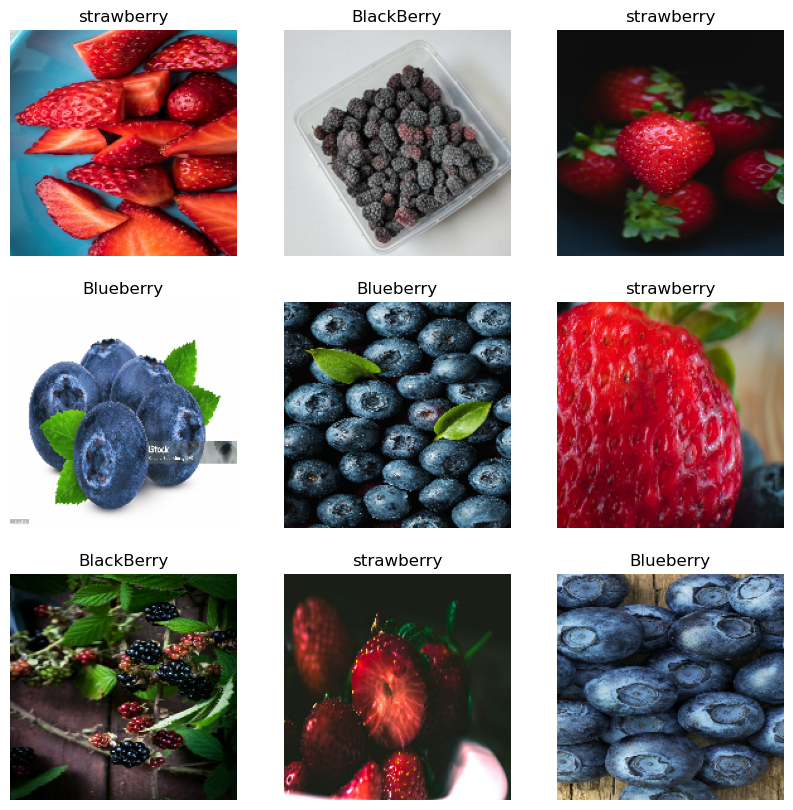

In [102]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))


for images, labels in data.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        


In [103]:
for images, labels in data.take(1):
    images_array = np.array(images)
    print(images_array.shape)
    

(16, 180, 180, 3)


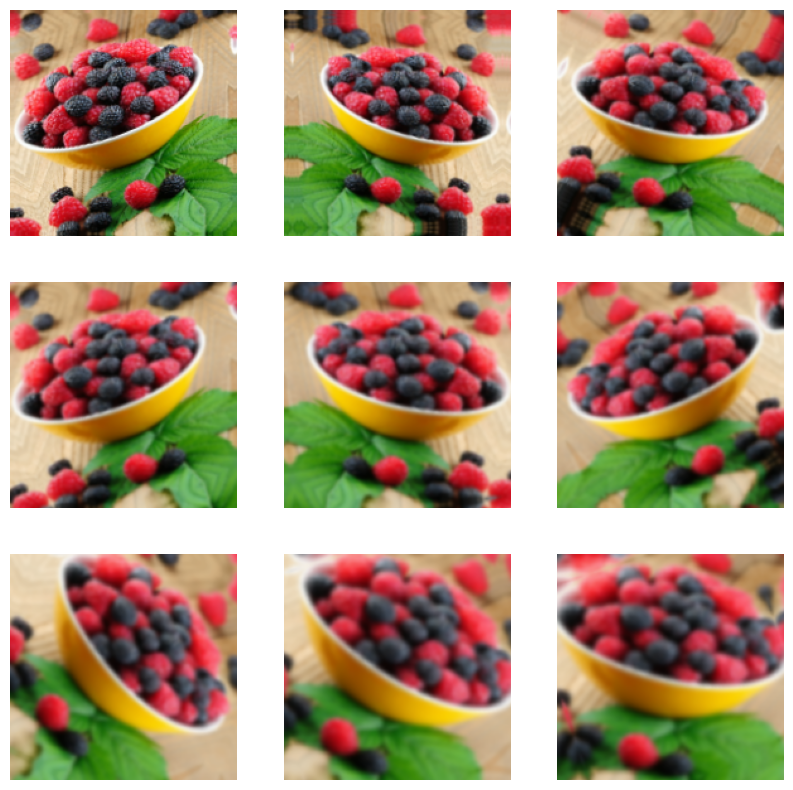

In [104]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

Tuner = tf.data.AUTOTUNE
train_ds = data.cache().shuffle(1000).prefetch(buffer_size = Tuner)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = Tuner)


data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(69):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [105]:
import tensorflow as tf
import keras

import keras._tf_keras.keras.backend as K
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Input, Dense, Conv2D
from keras._tf_keras.keras.layers import Flatten, MaxPool2D, AvgPool2D
from keras._tf_keras.keras.layers import Concatenate, Dropout

from keras._tf_keras.keras.models import load_model


def googlenet(input_shape, n_classes):
    
    def inception_block(x, f):
        t1 = Conv2D(f[0], 1, activation='relu')(x)

        t2 = Conv2D(f[1], 1, activation='relu')(x)
        t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)
 
        t3 = Conv2D(f[3], 1, activation='relu')(x)
        t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)

        t4 = MaxPool2D(3, 1, padding='same')(x)
        t4 = Conv2D(f[5], 1, activation='relu')(t4)

        output = Concatenate()([t1, t2, t3, t4])
        return output
  
  
    input = Input(input_shape)
    
    x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    x = Conv2D(64, 1, activation='relu')(x)
    x = Conv2D(192, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(3, strides=2)(x)
    
    x = inception_block(x, [64, 96, 128, 16, 32, 32])
    x = inception_block(x, [128, 128, 192, 32, 96, 64])
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    x = inception_block(x, [192, 96, 208, 16, 48, 64])
    x = inception_block(x, [160, 112, 224, 24, 64, 64])
    x = inception_block(x, [128, 128, 256, 24, 64, 64])
    x = inception_block(x, [112, 144, 288, 32, 64, 64])
    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = inception_block(x, [384, 192, 384, 48, 128, 128])
    
    x = AvgPool2D(3, strides=1)(x)
    x = Dropout(0.4)(x)
  
    x = Flatten()(x)
    output = Dense(n_classes, activation='softmax')(x)
    
    model = Model(input, output)
    return model

input_shape = 180, 180, 3   
n_classes = 3


K.clear_session()

model = googlenet(input_shape, n_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 90, 90,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 45, 45,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 45, 45,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 22, 22,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 22, 22,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 22, 22,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 22, 22,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 22, 22,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 22, 22,    │    110,720 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 22, 22,    │     12,832 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 22, 22,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 22, 22,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 22, 22,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 22, 22,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                 

 Total params: 6,022,707 (22.97 MB)

 Trainable params: 6,022,707 (22.97 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=5, 
                               mode='max')

history= model.fit(train_ds, 
                   epochs=30, 
                   validation_data=val_ds, 
                   callbacks=[early_stopping])

Epoch 1/30


19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 517ms/step - accuracy: 0.3718 - loss: 3.9434 - val_accuracy: 0.7500 - val_loss: 0.8545
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 443ms/step - accuracy: 0.5541 - loss: 1.2925 - val_accuracy: 0.5000 - val_loss: 0.6609
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - accuracy: 0.5584 - loss: 0.8697 - val_accuracy: 0.5000 - val_loss: 0.6908
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 488ms/step - accuracy: 0.6372 - loss: 0.5873 - val_accuracy: 0.6667 - val_loss: 0.5606
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 505ms/step - accuracy: 0.6697 - loss: 0.5532 - val_accuracy: 0.6667 - val_loss: 0.4984
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - accuracy: 0.7156 - loss: 0.5191 - val_accuracy: 1.0000 - val_loss: 0.2442
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 431ms/step - accuracy: 0.7473 - loss: 0.4696 - val_accuracy: 0.6667 - val_loss: 0.3492
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 416ms/step - accuracy: 0.7235 - loss: 0.5249 - val_accuracy: 0.5833 - va

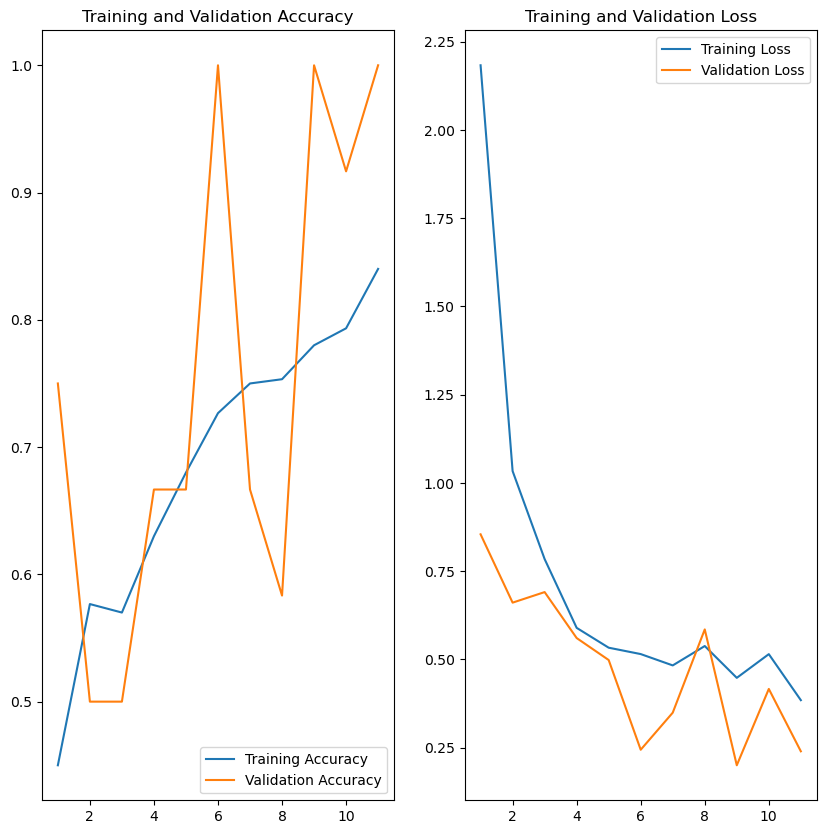

In [107]:
ephocs_range = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [116]:
model.save('BestModel_GoogleNet_Tensorflow.h5')

In [118]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image


model = load_model(r'C:\UAS_Bagian_GoogleNet\BestModel_GoogleNet_Tensorflow.h5')
class_names = ['BlackBerry', 'Blueberry', 'strawberry']


def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)

        
        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        
        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        
        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"


result = classify_images(r'C:\test_data_uas\Blueberry\625bcc28ebdb6b529bc8e680d8b96cae.jpg', save_path='bluee.jpg')
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
Prediksi: Blueberry
Confidence: 50.43%
Prediksi: Blueberry dengan confidence 50.43%. Gambar asli disimpan di bluee.jpg.


Found 30 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


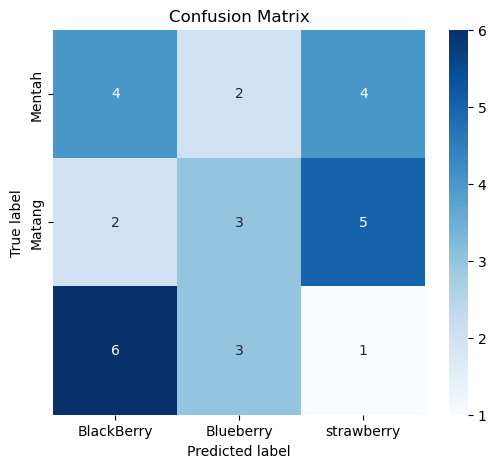

Confusion Matrix:
 [[4 2 4]
 [2 3 5]
 [6 3 1]]
Akurasi: 0.26666666666666666
Presisi: [0.33333333 0.375      0.1       ]
Recall: [0.4 0.3 0.1]
F1 Score: [0.36363636 0.33333333 0.1       ]


In [119]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt


test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\test_data_uas',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(180, 180)
)


y_pred = model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)


true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
true_labels = tf.convert_to_tensor(true_labels)


conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)


accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)


precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)


f1_score = 2 * (precision * recall) / (precision + recall)


plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=["BlackBerry", "Blueberry", "strawberry"], yticklabels=["Mentah", "Matang"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())
